<a href="https://colab.research.google.com/github/gkiflex/MSAI-630-A01/blob/master/ProGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating synthetic facial dataset...
Creating synthetic facial dataset...
Generated 1000/1000 synthetic faces
Starting ProGAN training...
Setting up ProGAN architecture...
Adding discriminator block. Old model input shape: [None, 4, 4, 3]
New input shape: (8, 8, 3)
Adding discriminator block. Old model input shape: [None, 8, 8, 3]
New input shape: (16, 16, 3)
Discriminator models created: 3 levels
Generator models created: 3 levels
Composite models created: 3 levels
Dataset shape: (1000, 32, 32, 3)

=== Training 4x4 resolution ===
Scaled data shape: (1000, 4, 4, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


>Step 100/124, d1=0.012, d2=0.012, g=-0.020


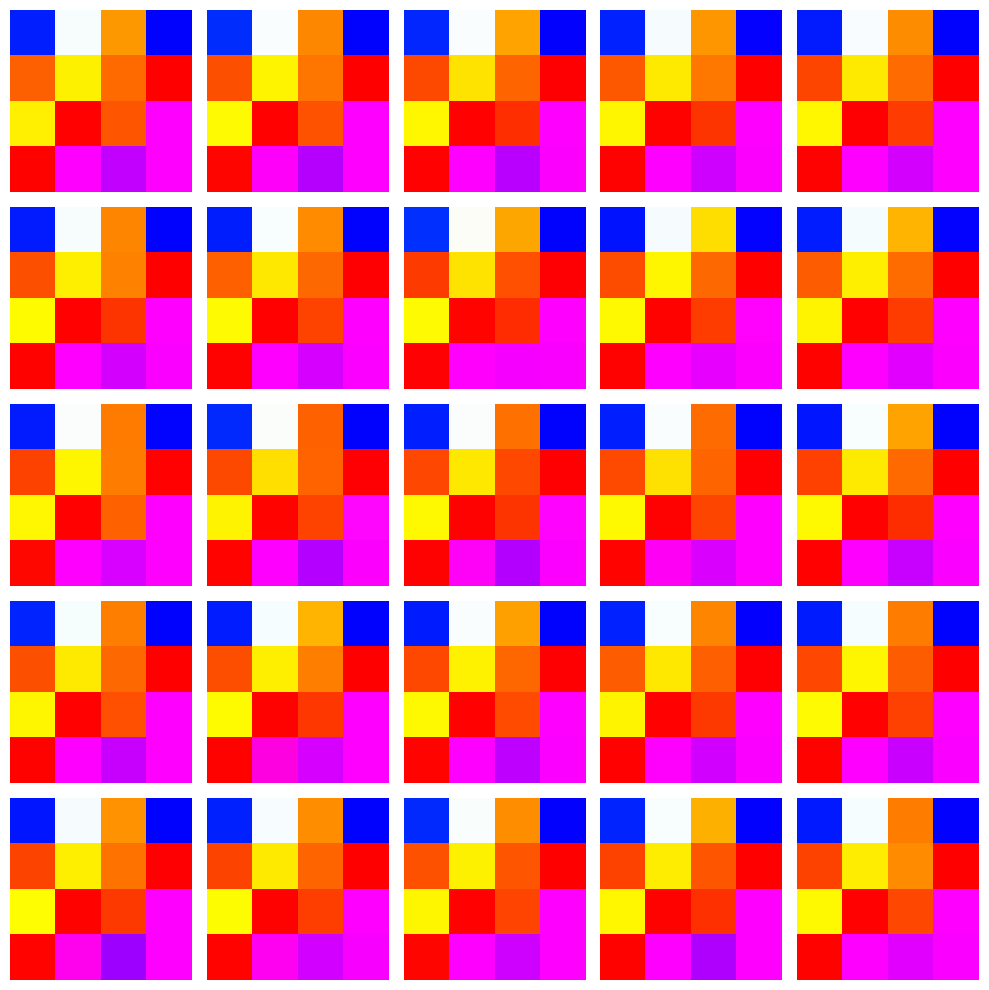

>Saved: plot_004x004-tuned.png and model_004x004-tuned.h5

=== Training 8x8 resolution ===
Scaled data shape: (1000, 8, 8, 3)
Training fade-in phase...
>Step 100/125, d1=0.010, d2=0.010, g=-0.017


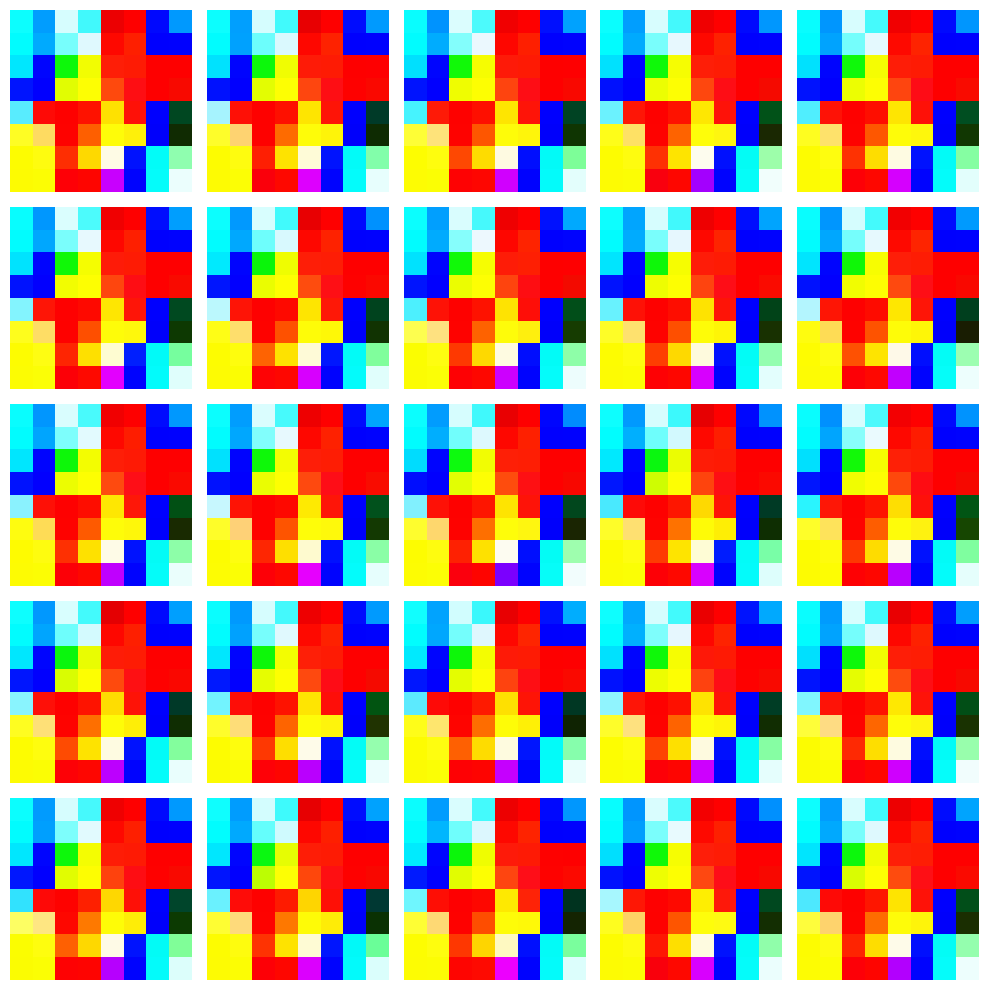

>Saved: plot_008x008-faded.png and model_008x008-faded.h5
Training stabilization phase...
>Step 100/250, d1=0.002, d2=0.002, g=-0.005
>Step 200/250, d1=0.002, d2=0.002, g=-0.005


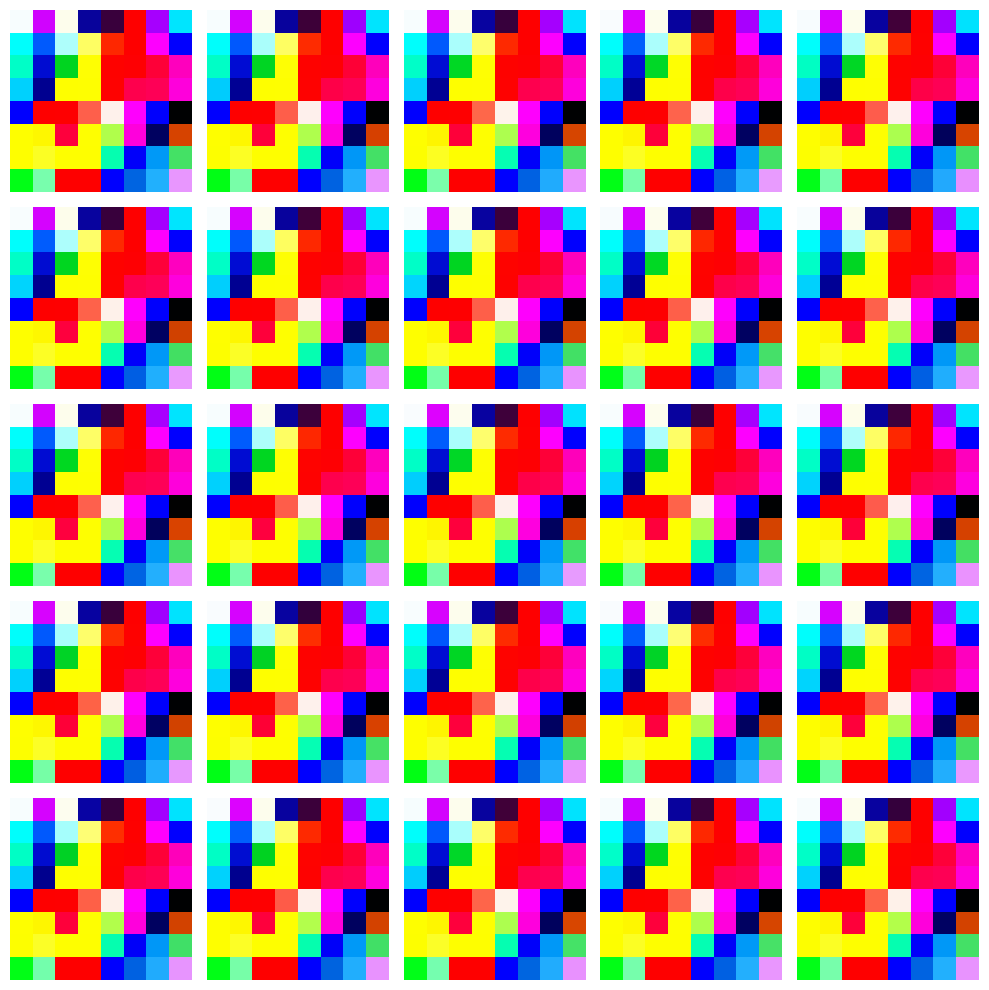

>Saved: plot_008x008-tuned.png and model_008x008-tuned.h5

=== Training 16x16 resolution ===
Scaled data shape: (1000, 16, 16, 3)
Training fade-in phase...
>Step 100/250, d1=0.002, d2=0.002, g=-0.004
>Step 200/250, d1=0.001, d2=0.001, g=-0.003


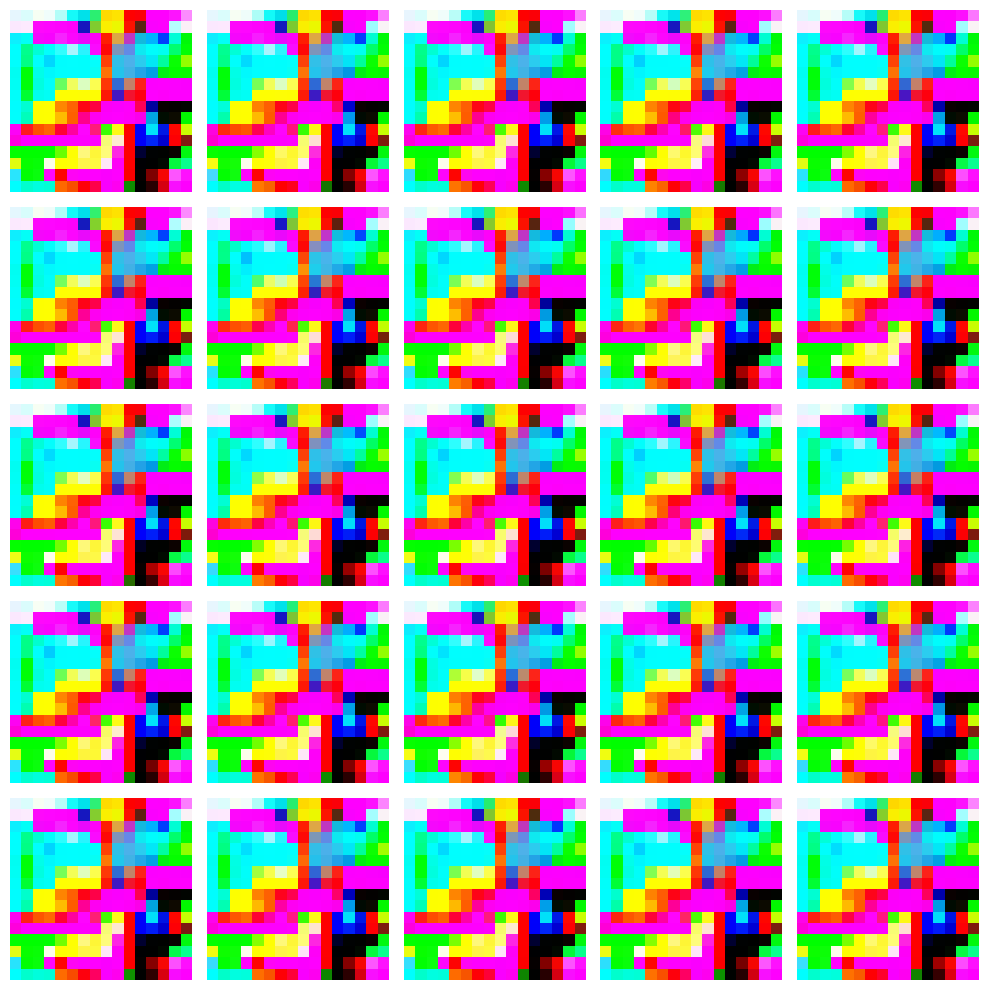

>Saved: plot_016x016-faded.png and model_016x016-faded.h5
Training stabilization phase...
>Step 100/500, d1=0.000, d2=0.000, g=-0.001
>Step 200/500, d1=0.000, d2=0.000, g=-0.001
>Step 300/500, d1=0.001, d2=0.001, g=-0.001
>Step 400/500, d1=0.001, d2=0.001, g=-0.001
>Step 500/500, d1=0.001, d2=0.001, g=-0.001


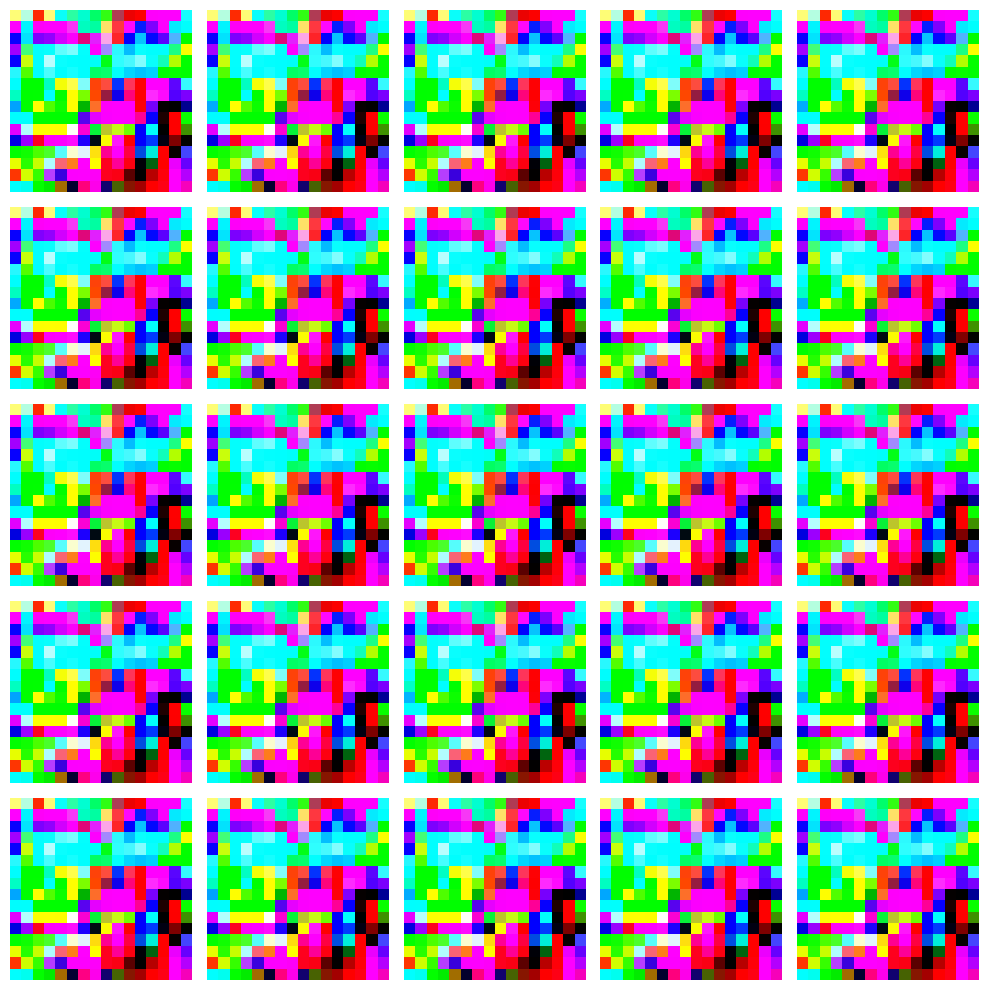

>Saved: plot_016x016-tuned.png and model_016x016-tuned.h5

ProGAN training completed!

Generating final results...


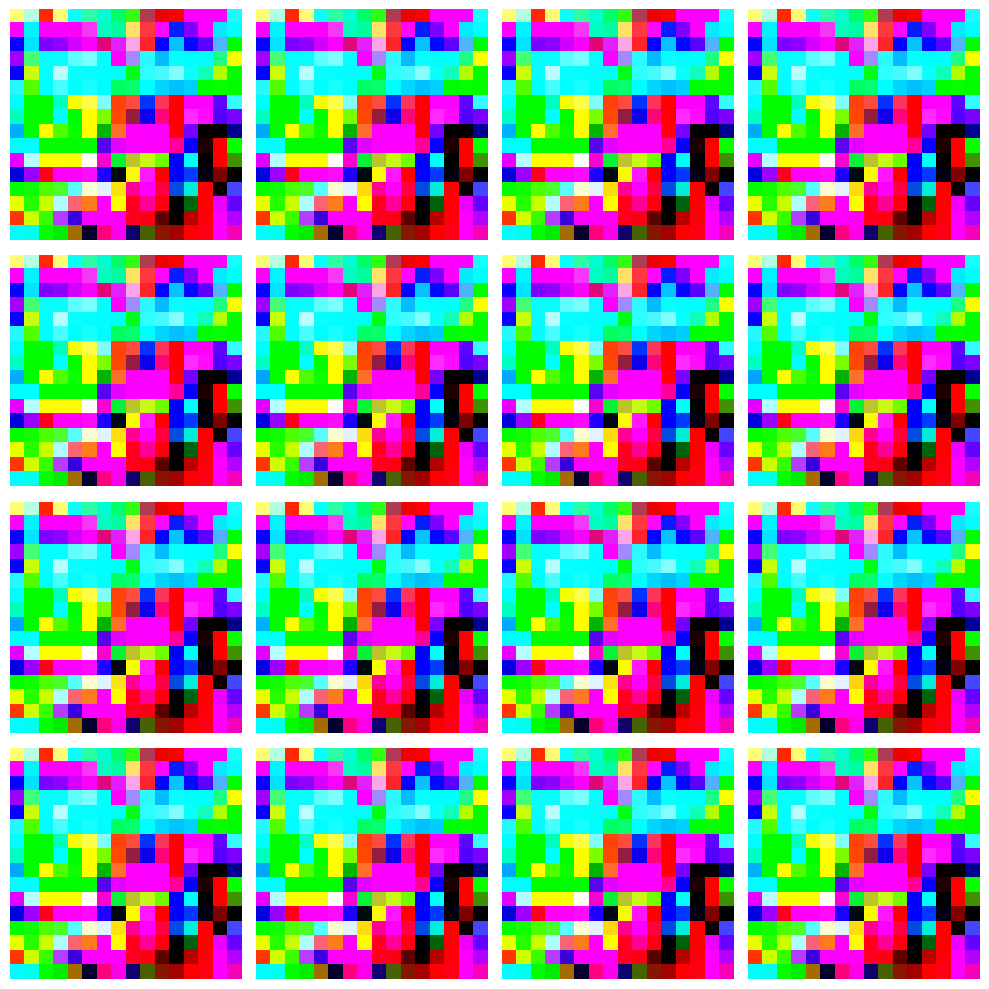

>Saved: plot_016x016-final.png and model_016x016-final.h5
Training completed! Check the generated plots and saved models.


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, LeakyReLU, Layer, Add
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from math import sqrt
from numpy.random import randn, randint
from PIL import Image
import cv2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PixelNormalization(Layer):
    """Pixel-wise feature vector normalization layer"""
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)

    def call(self, inputs):
        values = inputs**2.0
        mean_values = K.mean(values, axis=-1, keepdims=True)
        mean_values += 1.0e-8
        l2 = K.sqrt(mean_values)
        normalized = inputs / l2
        return normalized

    def compute_output_shape(self, input_shape):
        return input_shape

class MinibatchStdev(Layer):
    """Mini-batch standard deviation layer"""
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    def call(self, inputs):
        mean = K.mean(inputs, axis=0, keepdims=True)
        squ_diffs = K.square(inputs - mean)
        mean_sq_diff = K.mean(squ_diffs, axis=0, keepdims=True)
        mean_sq_diff += 1e-8
        stdev = K.sqrt(mean_sq_diff)
        mean_pix = K.mean(stdev, keepdims=True)
        shape = K.shape(inputs)
        output = K.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        combined = K.concatenate([inputs, output], axis=-1)
        return combined

    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1
        return tuple(input_shape)

class WeightedSum(Add):
    """Weighted sum output for smooth layer transitions"""
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = K.variable(alpha, name='ws_alpha')

    def _merge_function(self, inputs):
        assert (len(inputs) == 2)
        output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
        return output

def wasserstein_loss(y_true, y_pred):
    """Calculate Wasserstein loss"""
    return K.mean(y_true * y_pred)

def generate_real_samples(dataset, n_samples):
    """Select real samples from dataset"""
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_samples):
    """Generate points in latent space as input for the generator"""
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
    """Use generator to generate fake examples with class labels"""
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input, verbose=0)
    y = -np.ones((n_samples, 1))
    return X, y

def update_fadein(models, step, n_steps):
    """Update alpha value on each instance of WeightedSum"""
    alpha = step / float(n_steps - 1)
    for model in models:
        for layer in model.layers:
            if isinstance(layer, WeightedSum):
                K.set_value(layer.alpha, alpha)

def scale_dataset(images, new_shape):
    """Scale images to preferred size"""
    images_list = []
    for image in images:
        # Use PIL for better quality resizing
        img = Image.fromarray((image * 127.5 + 127.5).astype(np.uint8))
        img = img.resize((new_shape[1], new_shape[0]))
        new_image = np.array(img).astype(np.float32)
        new_image = (new_image - 127.5) / 127.5
        images_list.append(new_image)
    return np.array(images_list)

def add_generator_block(old_model):
    """Add a generator block for progressive growing"""
    init = RandomNormal(stddev=0.02)
    const = max_norm(1.0)
    block_end = old_model.layers[-2].output

    # Upsample and define new block
    upsampling = UpSampling2D(size=2)(block_end)
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(upsampling)
    g = PixelNormalization()(g)
    g = LeakyReLU(negative_slope=0.2)(g)
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(negative_slope=0.2)(g)
    out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const, activation='tanh')(g)
    model1 = Model(old_model.input, out_image)

    # Create fade-in model
    out_old = old_model.layers[-1]
    out_image2 = out_old(upsampling)
    merged = WeightedSum()([out_image2, out_image])
    model2 = Model(old_model.input, merged)
    return [model1, model2]

def define_generator(latent_dim, n_blocks, in_dim=4):
    """Define generator models for each image resolution"""
    init = RandomNormal(stddev=0.02)
    const = max_norm(1.0)
    model_list = []

    # Input layer
    in_latent = Input(shape=(latent_dim,))
    g = Dense(128 * in_dim * in_dim, kernel_initializer=init, kernel_constraint=const)(in_latent)
    g = Reshape((in_dim, in_dim, 128))(g)

    # Initial 4x4 block
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

    # Output block (RGB)
    out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const, activation='tanh')(g)
    model = Model(in_latent, out_image)
    model_list.append([model, model])

    # Add progressive blocks
    for i in range(1, n_blocks):
        old_model = model_list[i - 1][0]
        models = add_generator_block(old_model)
        model_list.append(models)

    return model_list

def add_discriminator_block(old_model, n_input_layers=3):
    """Add a discriminator block for progressive growing"""
    init = RandomNormal(stddev=0.02)
    const = max_norm(1.0)
    in_shape = list(old_model.input.shape)

    print(f"Adding discriminator block. Old model input shape: {in_shape}")

    # Define new input shape as double the size
    input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])
    print(f"New input shape: {input_shape}")

    in_image = Input(shape=input_shape)

    # Define new input processing layer
    d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(negative_slope=0.2)(d)

    # Define new block
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(negative_slope=0.2)(d)
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(negative_slope=0.2)(d)
    d = AveragePooling2D(pool_size=2)(d)
    block_new = d

    # Skip input, 1x1, and activation for old model
    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)

    model1 = Model(in_image, d)
    model1.compile(loss=wasserstein_loss, optimizer=Adam(learning_rate=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

    # Create fade-in model
    downsample = AveragePooling2D(pool_size=2)(in_image)
    try:
        block_old = old_model.layers[1](downsample)
        block_old = old_model.layers[2](block_old)
    except IndexError:
        # If there aren't enough layers, use a simpler approach
        block_old = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(downsample)
        block_old = LeakyReLU(negative_slope=0.2)(block_old)
    d = WeightedSum()([block_old, block_new])

    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)

    model2 = Model(in_image, d)
    model2.compile(loss=wasserstein_loss, optimizer=Adam(learning_rate=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

    return [model1, model2]

def define_discriminator(n_blocks, input_shape=(4,4,3)):
    """Define discriminator models for each image resolution"""
    init = RandomNormal(stddev=0.02)
    const = max_norm(1.0)
    model_list = []

    # Input layer
    in_image = Input(shape=input_shape)
    d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(negative_slope=0.2)(d)
    d = MinibatchStdev()(d)
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(negative_slope=0.2)(d)
    d = Conv2D(128, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(negative_slope=0.2)(d)
    d = Flatten()(d)
    out_class = Dense(1)(d)

    model = Model(in_image, out_class)
    model.compile(loss=wasserstein_loss, optimizer=Adam(learning_rate=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
    model_list.append([model, model])

    # Add progressive blocks
    for i in range(1, n_blocks):
        old_model = model_list[i - 1][0]
        models = add_discriminator_block(old_model)
        model_list.append(models)

    return model_list

def define_composite(discriminators, generators):
    """Define composite models for training generators via discriminators"""
    model_list = []

    for i in range(len(discriminators)):
        g_models, d_models = generators[i], discriminators[i]

        # Straight-through model
        d_models[0].trainable = False
        model1 = Sequential()
        model1.add(g_models[0])
        model1.add(d_models[0])
        model1.compile(loss=wasserstein_loss, optimizer=Adam(learning_rate=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

        # Fade-in model
        d_models[1].trainable = False
        model2 = Sequential()
        model2.add(g_models[1])
        model2.add(d_models[1])
        model2.compile(loss=wasserstein_loss, optimizer=Adam(learning_rate=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

        model_list.append([model1, model2])

    return model_list

def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, latent_dim, fadein=False):
    """Train a generator and discriminator for specified epochs"""
    bat_per_epo = int(dataset.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    half_batch = int(n_batch / 2)

    for i in range(n_steps):
        # Update alpha for all WeightedSum layers when fading in new blocks
        if fadein:
            update_fadein([g_model, d_model, gan_model], i, n_steps)

        # Prepare real and fake samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

        # Update discriminator model
        d_loss1 = d_model.train_on_batch(X_real, y_real)
        d_loss2 = d_model.train_on_batch(X_fake, y_fake)

        # Update generator via discriminator's error
        z_input = generate_latent_points(latent_dim, n_batch)
        y_real2 = np.ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(z_input, y_real2)

        # Print progress every 100 steps
        if (i + 1) % 100 == 0:
            print(f'>Step {i+1}/{n_steps}, d1={d_loss1:.3f}, d2={d_loss2:.3f}, g={g_loss:.3f}')

def summarize_performance(status, g_model, latent_dim, n_samples=25):
    """Generate samples and save as plot"""
    gen_shape = g_model.output_shape
    name = f'{gen_shape[1]:03d}x{gen_shape[2]:03d}-{status}'

    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0  # Scale from [-1, 1] to [0, 1]

    square = int(sqrt(n_samples))
    plt.figure(figsize=(10, 10))

    for i in range(n_samples):
        plt.subplot(square, square, 1 + i)
        plt.axis('off')
        plt.imshow(X[i])

    plt.tight_layout()
    filename = f'plot_{name}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

    # Save model
    model_filename = f'model_{name}.h5'
    g_model.save(model_filename)
    print(f'>Saved: {filename} and {model_filename}')

def create_synthetic_dataset(n_samples=10000, img_size=64):
    """Create a synthetic facial dataset for demonstration"""
    print("Creating synthetic facial dataset...")
    np.random.seed(42)

    # Create synthetic face-like patterns
    dataset = []
    for i in range(n_samples):
        # Create a base face structure
        img = np.zeros((img_size, img_size, 3))

        # Add face oval
        center_x, center_y = img_size//2, img_size//2
        for y in range(img_size):
            for x in range(img_size):
                dist_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
                if dist_center < img_size//3:
                    # Skin tone variation
                    skin_tone = 0.6 + np.random.normal(0, 0.1)
                    img[y, x] = [skin_tone, skin_tone * 0.9, skin_tone * 0.8]

        # Add eyes
        eye_y = img_size//3
        left_eye_x = img_size//3
        right_eye_x = 2*img_size//3

        for eye_x in [left_eye_x, right_eye_x]:
            for dy in range(-3, 4):
                for dx in range(-5, 6):
                    if 0 <= eye_y + dy < img_size and 0 <= eye_x + dx < img_size:
                        if dx**2 + dy**2 <= 12:
                            img[eye_y + dy, eye_x + dx] = [0.1, 0.1, 0.1]

        # Add nose
        nose_x = img_size//2
        nose_y = img_size//2
        for dy in range(-2, 3):
            for dx in range(-1, 2):
                if 0 <= nose_y + dy < img_size and 0 <= nose_x + dx < img_size:
                    img[nose_y + dy, nose_x + dx] *= 0.9

        # Add mouth
        mouth_y = 2*img_size//3
        mouth_x = img_size//2
        for dx in range(-8, 9):
            if 0 <= mouth_x + dx < img_size:
                img[mouth_y, mouth_x + dx] = [0.3, 0.1, 0.1]

        # Add noise and variations
        noise = np.random.normal(0, 0.05, img.shape)
        img = np.clip(img + noise, 0, 1)

        # Convert to [-1, 1] range
        img = (img * 2.0) - 1.0
        dataset.append(img)

        if (i + 1) % 1000 == 0:
            print(f"Generated {i+1}/{n_samples} synthetic faces")

    return np.array(dataset)

def train_progan(dataset, latent_dim=100, n_blocks=3):
    """Main training function for ProGAN"""
    print("Setting up ProGAN architecture...")

    try:
        # Define models
        d_models = define_discriminator(n_blocks)
        print(f"Discriminator models created: {len(d_models)} levels")

        g_models = define_generator(latent_dim, n_blocks)
        print(f"Generator models created: {len(g_models)} levels")

        gan_models = define_composite(d_models, g_models)
        print(f"Composite models created: {len(gan_models)} levels")

    except Exception as e:
        print(f"Error creating models: {e}")
        raise

    print(f'Dataset shape: {dataset.shape}')

    # Training configuration for each resolution
    # Reduced epochs and batch sizes for faster demonstration
    n_batch = [16, 8, 4][:n_blocks]
    n_epochs_normal = [2, 2, 2][:n_blocks]
    n_epochs_fadein = [1, 1, 1][:n_blocks]

    # Train initial 4x4 model
    print("\n=== Training 4x4 resolution ===")
    g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
    gen_shape = g_normal.output_shape
    scaled_data = scale_dataset(dataset, gen_shape[1:])
    print(f'Scaled data shape: {scaled_data.shape}')

    train_epochs(g_normal, d_normal, gan_normal, scaled_data, n_epochs_normal[0], n_batch[0], latent_dim)
    summarize_performance('tuned', g_normal, latent_dim)

    # Process each level of growth
    for i in range(1, len(g_models)):
        resolution = 4 * (2 ** i)
        print(f"\n=== Training {resolution}x{resolution} resolution ===")

        # Retrieve models for this level
        [g_normal, g_fadein] = g_models[i]
        [d_normal, d_fadein] = d_models[i]
        [gan_normal, gan_fadein] = gan_models[i]

        # Scale dataset to appropriate size
        gen_shape = g_normal.output_shape
        scaled_data = scale_dataset(dataset, gen_shape[1:])
        print(f'Scaled data shape: {scaled_data.shape}')

        # Train fade-in models
        print(f"Training fade-in phase...")
        train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, n_epochs_fadein[i], n_batch[i], latent_dim, True)
        summarize_performance('faded', g_fadein, latent_dim)

        # Train normal models
        print(f"Training stabilization phase...")
        train_epochs(g_normal, d_normal, gan_normal, scaled_data, n_epochs_normal[i], n_batch[i], latent_dim)
        summarize_performance('tuned', g_normal, latent_dim)

    print("\nProGAN training completed!")
    return g_models, d_models, gan_models

# Example usage and training
if __name__ == "__main__":
    # Configuration
    LATENT_DIM = 100
    N_BLOCKS = 3  # Will generate up to 16x16 images (4, 8, 16) for faster demo
    N_SAMPLES = 1000  # Further reduced for faster demonstration

    try:
        # Create synthetic dataset (in practice, use real facial images)
        print("Creating synthetic facial dataset...")
        synthetic_dataset = create_synthetic_dataset(n_samples=N_SAMPLES, img_size=32)

        # Train ProGAN
        print("Starting ProGAN training...")
        g_models, d_models, gan_models = train_progan(synthetic_dataset, LATENT_DIM, N_BLOCKS)

        # Generate final results
        print("\nGenerating final results...")
        final_generator = g_models[-1][0]  # Get the highest resolution generator
        summarize_performance('final', final_generator, LATENT_DIM, n_samples=16)

        print("Training completed! Check the generated plots and saved models.")

    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()